## Model

In [930]:
## For Model
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from fredapi import Fred
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import math
from scipy.stats import shapiro
from pylab import rcParams
from sklearn.model_selection import TimeSeriesSplit




[*********************100%***********************]  2 of 2 completed


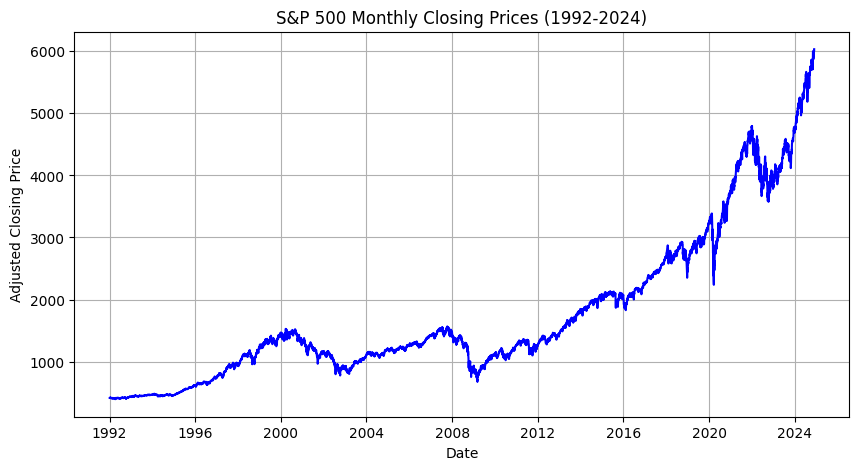

Date
1992-01-02 00:00:00+00:00     417.260010
1992-01-03 00:00:00+00:00     419.339996
1992-01-06 00:00:00+00:00     417.959991
1992-01-07 00:00:00+00:00     417.399994
1992-01-08 00:00:00+00:00     418.100006
                                ...     
2024-11-22 00:00:00+00:00    5969.339844
2024-11-25 00:00:00+00:00    5987.370117
2024-11-26 00:00:00+00:00    6021.629883
2024-11-27 00:00:00+00:00    5998.740234
2024-11-29 00:00:00+00:00    6032.379883
Name: ^GSPC, Length: 8290, dtype: float64


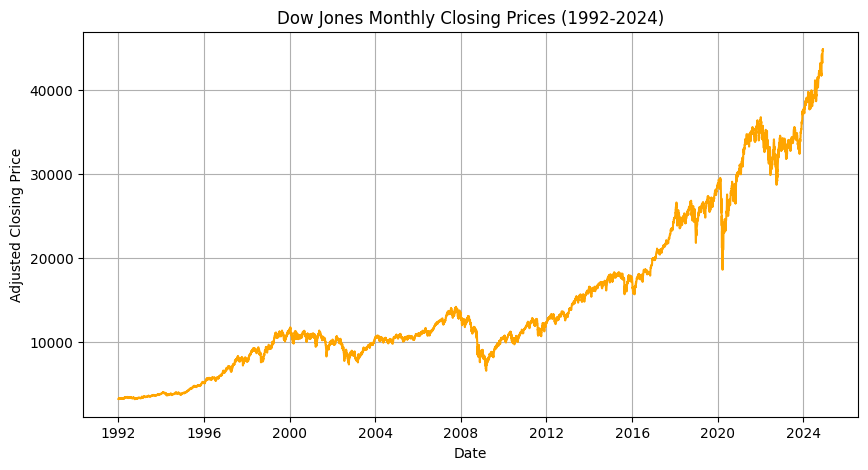

Date
1992-01-02 00:00:00+00:00     3172.399902
1992-01-03 00:00:00+00:00     3201.500000
1992-01-06 00:00:00+00:00     3200.100098
1992-01-07 00:00:00+00:00     3204.800049
1992-01-08 00:00:00+00:00     3203.899902
                                 ...     
2024-11-22 00:00:00+00:00    44296.511719
2024-11-25 00:00:00+00:00    44736.570312
2024-11-26 00:00:00+00:00    44860.308594
2024-11-27 00:00:00+00:00    44722.058594
2024-11-29 00:00:00+00:00    44910.648438
Name: ^DJI, Length: 8290, dtype: float64


In [931]:
# S&P 500 and Dow Jones data from Yahoo Finance
# Stock Market Data
start_date = '1992-01-02'

tickers = ["^GSPC", "^DJI"]
stock_market_data = yf.download(
    tickers, start=start_date, 
    end="2024-12-01",
    interval="1d"
)

sp500_data = stock_market_data["Adj Close"]["^GSPC"]

dowjones_data = stock_market_data["Adj Close"]["^DJI"]

dowjones_data = dowjones_data.dropna()

# Plot for S&P 500
plt.figure(figsize=(10, 5))
plt.plot(sp500_data.index, sp500_data, color="blue")
plt.title("S&P 500 Monthly Closing Prices (1992-2024)")
plt.xlabel("Date")
plt.ylabel("Adjusted Closing Price")
plt.grid()
plt.show()

print(sp500_data)

# Plot for Dow Jones
plt.figure(figsize=(10, 5))
plt.plot(dowjones_data.index, dowjones_data, color="orange")
plt.title("Dow Jones Monthly Closing Prices (1992-2024)")
plt.xlabel("Date")
plt.ylabel("Adjusted Closing Price")
plt.grid()
plt.show()

print(dowjones_data)

Old              Real GDP
date                 
1947-01-01   2182.681
1947-04-01   2176.892
1947-07-01   2172.432
1947-10-01   2206.452
1948-01-01   2239.682
...               ...
2023-04-01  22539.418
2023-07-01  22780.933
2023-10-01  22960.600
2024-01-01  23053.545
2024-04-01  23223.906

[310 rows x 1 columns]


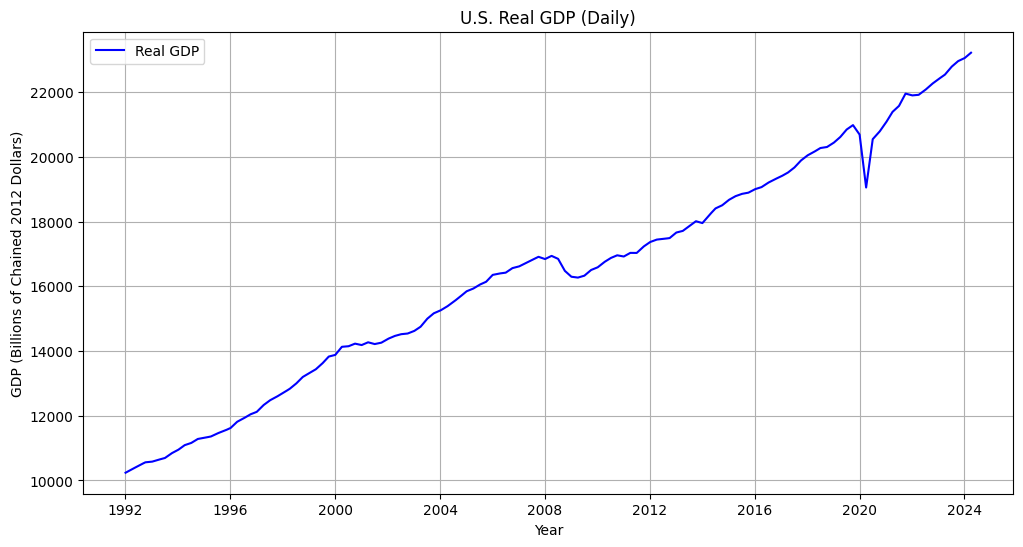

New                 Real GDP
1992-01-02  10237.654714
1992-01-03  10238.874429
1992-01-04  10240.094143
1992-01-05  10241.313857
1992-01-06  10242.533571
...                  ...
2024-03-28  23216.417604
2024-03-29  23218.289703
2024-03-30  23220.161802
2024-03-31  23222.033901
2024-04-01  23223.906000

[11779 rows x 1 columns]


In [932]:
# GDP data from FRED
gdp_data = pd.read_csv("gdp_data_1965_2024.csv")

gdp_data.rename(columns={
    "Unnamed: 0": "date"
}, inplace=True)
gdp_data['date'] = pd.to_datetime(gdp_data['date'])

gdp_data.set_index("date", inplace=True)

daily_index = pd.date_range(
    start=gdp_data.index.min(), 
    end=gdp_data.index.max(), 
    freq='D'
)

gdp_data_daily = gdp_data.reindex(daily_index)

gdp_data_daily['Real GDP'] = gdp_data_daily['Real GDP'].interpolate(method='linear')

gdp_data_daily = gdp_data_daily.loc[start_date:]

print("Old",gdp_data)
# Plot for GDP
plt.figure(figsize=(12, 6))
plt.plot(
    gdp_data_daily.index,
    gdp_data_daily["Real GDP"],
    color="blue",
    label="Real GDP",
)
plt.title("U.S. Real GDP (Daily)")
plt.xlabel("Year")
plt.ylabel("GDP (Billions of Chained 2012 Dollars)")
plt.grid()
plt.legend()
plt.show()

print("New",gdp_data_daily)

Old
     Year   Jan   Feb   Mar   Apr   May   Jun   Jul  Aug  Sep  Oct   Nov   Dec
0   1965   5.5   5.7   5.1   4.7   4.3   5.3   4.5  4.2  3.8  3.6   3.9   3.7
1   1966   4.4   4.2   4.0   3.6   3.7   4.6   3.9  3.6  3.3  3.2   3.4   3.5
2   1967   4.2   4.2   3.9   3.5   3.2   4.6   4.1  3.7  3.7  3.8   3.7   3.5
3   1968   4.0   4.2   3.8   3.2   2.9   4.5   4.0  3.5  3.3  3.2   3.3   3.1
4   1969   3.7   3.7   3.5   3.2   2.9   4.1   3.8  3.5  3.7  3.5   3.3   3.2
5   1970   4.2   4.7   4.6   4.3   4.1   5.6   5.3  5.0  5.2  5.1   5.5   5.6
6   1971   6.6   6.6   6.3   5.7   5.3   6.5   6.2  5.9  5.8  5.4   5.7   5.5
7   1972   6.5   6.4   6.1   5.5   5.1   6.2   5.9  5.5  5.4  5.1   4.9   4.8
8   1973   5.5   5.6   5.2   4.8   4.4   5.4   5.0  4.7  4.7  4.2   4.6   4.6
9   1974   5.7   5.8   5.3   4.8   4.6   5.8   5.7  5.3  5.7  5.5   6.2   6.7
10  1975   9.0   9.1   9.1   8.6   8.3   9.1   8.7  8.2  8.1  7.8   7.8   7.8
11  1976   8.8   8.7   8.1   7.4   6.8   8.0   7.8  7.6  7.

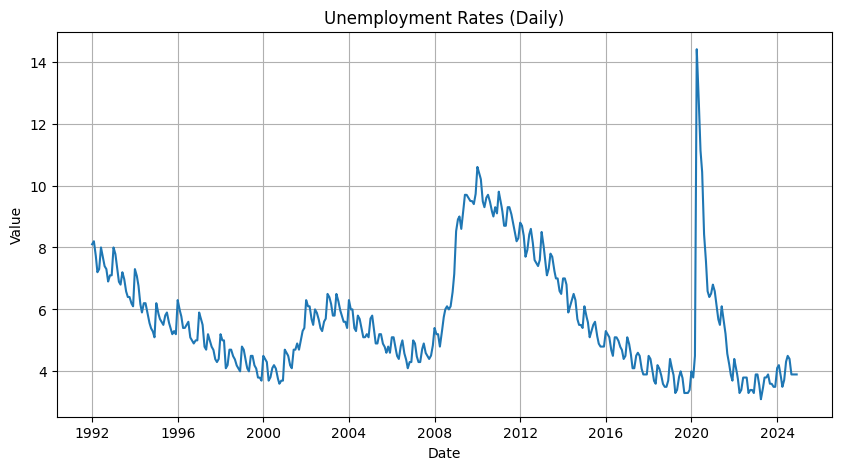

New
               Year      Month     Value
Date                                   
1992-01-02  1992.0   1.032258  8.103226
1992-01-03  1992.0   1.064516  8.106452
1992-01-04  1992.0   1.096774  8.109677
1992-01-05  1992.0   1.129032  8.112903
1992-01-06  1992.0   1.161290  8.116129
...            ...        ...       ...
2024-11-27  2024.0  11.866667  3.900000
2024-11-28  2024.0  11.900000  3.900000
2024-11-29  2024.0  11.933333  3.900000
2024-11-30  2024.0  11.966667  3.900000
2024-12-01  2024.0  12.000000  3.900000

[12023 rows x 3 columns]


In [933]:
# Unemployment Data
unemployment_data = pd.read_csv("unemployment_data.csv")

unemployment_data_long = unemployment_data.melt(
    id_vars=["Year"], var_name="Month", value_name="Value"
)

unemployment_data_long["Month"] = pd.to_datetime(
    unemployment_data_long["Month"], format="%b"
).dt.month

unemployment_data_long["Date"] = pd.to_datetime(
    unemployment_data_long[["Year", "Month"]].assign(Day=1)
)

unemployment_data_long = unemployment_data_long.sort_values("Date")

unemployment_data_long.set_index("Date", inplace=True)

daily_index = pd.date_range(
    start=unemployment_data_long.index.min(), 
    end="2024-12-01", 
    freq='D')

unemployment_data_daily = unemployment_data_long.reindex(daily_index)

unemployment_data_daily = unemployment_data_daily.interpolate(method='linear')

unemployment_data_daily = unemployment_data_daily.loc[start_date:]

unemployment_data_daily.index.name = 'Date'

print("Old\n",unemployment_data)
# Plot for unemployment rate
plt.figure(figsize=(10, 5))
plt.plot(unemployment_data_daily.index, unemployment_data_daily["Value"])
plt.title("Unemployment Rates (Daily)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid()
plt.show()

print("New\n",unemployment_data_daily)

Old
     Year   Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep   Oct   Nov  \
0   1965   1.6   1.6   1.2   1.6   1.6   1.2   1.2   1.6   1.5   1.5   1.2   
1   1966   0.9   1.2   1.5   1.8   2.1   2.4   2.8   3.1   3.0   3.3   3.6   
2   1967   3.6   3.6   3.6   3.3   3.3   3.3   3.3   3.3   3.6   3.5   3.5   
3   1968   4.1   4.1   4.4   4.4   4.3   4.6   4.9   4.9   4.9   4.8   5.1   
4   1969   5.1   5.3   5.6   6.1   6.1   5.8   5.8   5.8   6.0   6.0   5.9   
5   1970   6.2   6.1   6.1   5.8   6.0   6.5   6.2   6.2   6.2   6.4   6.6   
6   1971   6.3   5.8   5.2   5.0   5.2   4.9   4.9   4.6   4.4   3.8   3.3   
7   1972   3.1   3.3   3.3   3.3   3.1   2.8   2.8   3.3   2.8   3.0   3.0   
8   1973   2.8   2.8   3.0   3.2   3.2   3.2   3.2   3.2   3.8   4.3   4.5   
9   1974   4.9   5.4   5.8   6.2   6.8   7.9   8.8   9.6  10.2  10.6  11.2   
10  1975  11.5  11.7  11.4  11.3  10.5   9.6   9.1   8.2   7.7   7.0   6.8   
11  1976   6.7   6.5   6.6   6.4   6.5   6.5   6.7   6.8   

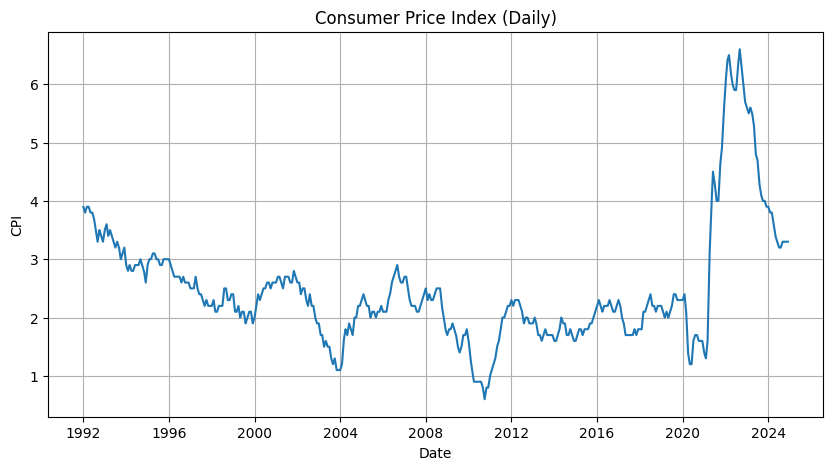

New
               Year  Month       CPI
Date                               
1992-01-02  1992.0    1.0  3.896774
1992-01-03  1992.0    1.0  3.893548
1992-01-04  1992.0    1.0  3.890323
1992-01-05  1992.0    1.0  3.887097
1992-01-06  1992.0    1.0  3.883871
...            ...    ...       ...
2024-11-27  2024.0   11.0  3.300000
2024-11-28  2024.0   11.0  3.300000
2024-11-29  2024.0   11.0  3.300000
2024-11-30  2024.0   11.0  3.300000
2024-12-01  2024.0   12.0  3.300000

[12023 rows x 3 columns]


In [934]:
# CPI Data
cpi_data = pd.read_csv("cpi_data.csv")
cpi_data.drop(columns=["HALF1", "HALF2"], inplace=True)
cpi_data_long = cpi_data.melt(id_vars=["Year"], var_name="Month", value_name="CPI")
cpi_data_long["Month"] = pd.to_datetime(cpi_data_long["Month"], format="%b").dt.month
cpi_data_long["Date"] = pd.to_datetime(cpi_data_long[["Year", "Month"]].assign(Day=1))
cpi_data_long = cpi_data_long.sort_values("Date")

daily_index = pd.date_range(start=cpi_data_long['Date'].min(), 
                            end=cpi_data_long['Date'].max(), 
                            freq='D')

cpi_data_daily = cpi_data_long.set_index('Date').reindex(daily_index)

cpi_data_daily['CPI'] = cpi_data_daily['CPI'].interpolate(method='linear')
cpi_data_daily['Year'] = cpi_data_daily['Year'].fillna(method="ffill")
cpi_data_daily['Month'] = cpi_data_daily['Month'].fillna(method="ffill")

cpi_data_daily.index.name = 'Date'

cpi_data_daily = cpi_data_daily.loc[start_date:]

print("Old\n",cpi_data)

# Plot for CPI
plt.figure(figsize=(10, 5))
plt.plot(cpi_data_daily.index, cpi_data_daily["CPI"])
plt.title("Consumer Price Index (Daily)")
plt.xlabel("Date")
plt.ylabel("CPI")
plt.grid()
plt.show()

print("New\n",cpi_data_daily)

Old
             Federal Funds Rate  10-Year Treasury Rate
1962-02-01                2.37                   4.09
1962-03-01                2.85                   3.98
1962-05-01                2.36                   3.85
1962-06-01                2.68                   3.89
1962-08-01                2.93                   4.03
...                        ...                    ...
2024-03-01                5.33                   4.19
2024-04-01                5.33                   4.33
2024-05-01                5.33                   4.63
2024-07-01                5.33                   4.48
2024-08-01                5.33                   3.99

[483 rows x 2 columns]


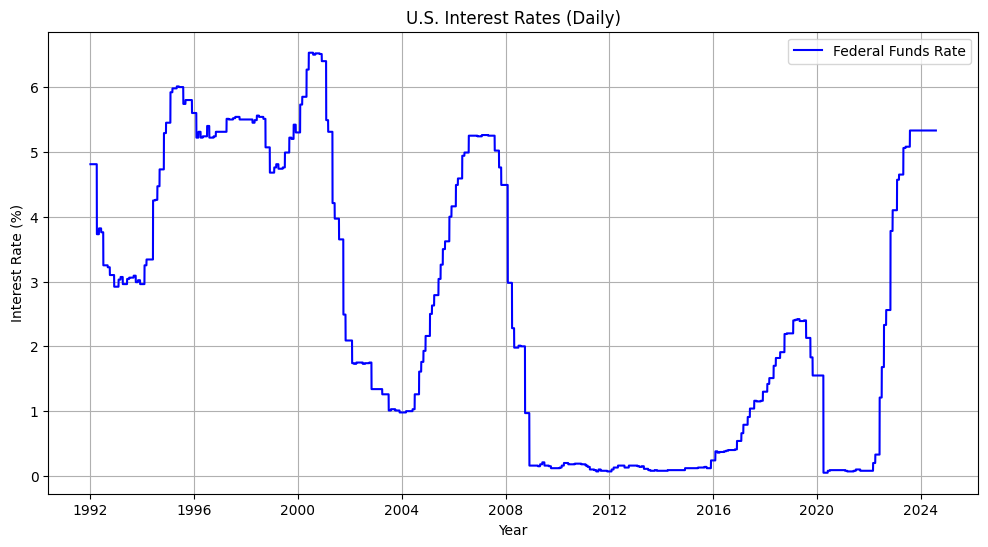

New
             Federal Funds Rate  10-Year Treasury Rate
Date                                                 
1992-01-02                4.81                   7.48
1992-01-03                4.81                   7.48
1992-01-04                4.81                   7.48
1992-01-05                4.81                   7.48
1992-01-06                4.81                   7.48
...                        ...                    ...
2024-07-28                5.33                   4.48
2024-07-29                5.33                   4.48
2024-07-30                5.33                   4.48
2024-07-31                5.33                   4.48
2024-08-01                5.33                   3.99

[11901 rows x 2 columns]


In [935]:
# Interest Rates Data
interest_rates_df = pd.read_csv(
    "interest_rates_1965_2024.csv", index_col=0, parse_dates=True
)

interest_rates_df = interest_rates_df.dropna()

daily_index = pd.date_range(start=interest_rates_df.index.min(), 
                            end=interest_rates_df.index.max(), 
                            freq='D')

interest_rates_daily = interest_rates_df.reindex(daily_index)

interest_rates_daily = interest_rates_daily.fillna(method='ffill')

interest_rates_daily.index.name = 'Date'

interest_rates_daily = interest_rates_daily.loc[start_date:]

print("Old\n",interest_rates_df)

# Plot for Interest Rates
plt.figure(figsize=(12, 6))
plt.plot(
    interest_rates_daily.index,
    interest_rates_daily["Federal Funds Rate"],
    label="Federal Funds Rate",
    color="blue",
)
plt.title("U.S. Interest Rates (Daily)")
plt.xlabel("Year")
plt.ylabel("Interest Rate (%)")
plt.legend()
plt.grid()
plt.show()

print("New\n",interest_rates_daily)

Old
             Consumer Confidence Index
1952-11-01                      86.20
1952-12-01                      87.70
1953-01-01                      89.20
1953-02-01                      90.70
1953-03-01                      89.05
...                               ...
2024-05-01                      69.10
2024-06-01                      68.20
2024-07-01                      66.40
2024-08-01                      67.90
2024-09-01                      70.10

[863 rows x 1 columns]


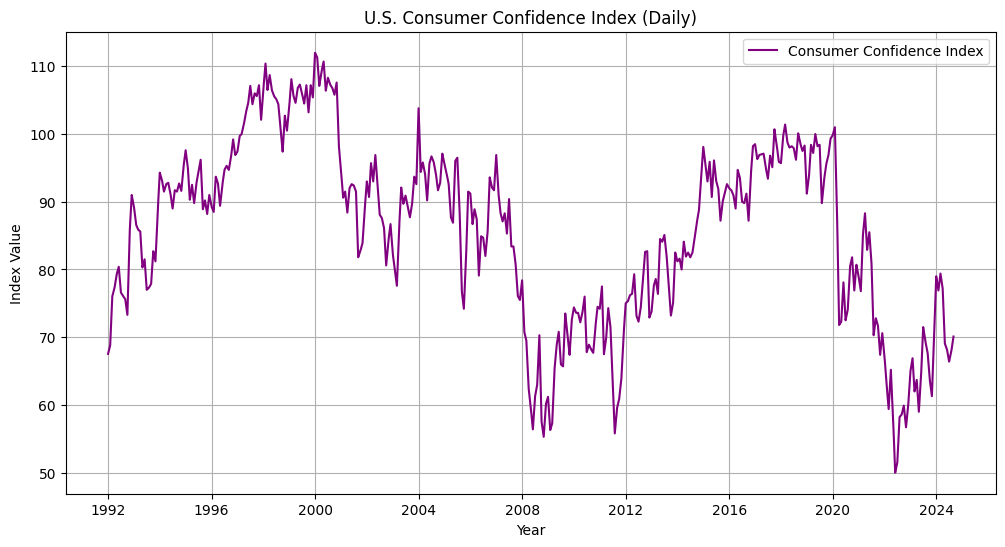

New
             Consumer Confidence Index
Date                                 
1992-01-02                  67.541935
1992-01-03                  67.583871
1992-01-04                  67.625806
1992-01-05                  67.667742
1992-01-06                  67.709677
...                               ...
2024-08-28                  69.816129
2024-08-29                  69.887097
2024-08-30                  69.958065
2024-08-31                  70.029032
2024-09-01                  70.100000

[11932 rows x 1 columns]


In [936]:
# Consumer Confidence Index Data
consumer_confidence_df = pd.read_csv(
    "consumer_confidence_index_1965_2024.csv", index_col=0, parse_dates=True
)

consumer_confidence_df = consumer_confidence_df.interpolate(method="linear")

daily_index = pd.date_range(start=consumer_confidence_df.index.min(), 
                            end=consumer_confidence_df.index.max(), 
                            freq='D')

consumer_confidence_daily = consumer_confidence_df.reindex(daily_index)

consumer_confidence_daily = consumer_confidence_daily.interpolate(method="linear")

consumer_confidence_daily.index.name = 'Date'

consumer_confidence_daily = consumer_confidence_daily.loc[start_date:]

print("Old\n",consumer_confidence_df)

# Plot for Consumer Confidence Index
plt.figure(figsize=(12, 6))
plt.plot(
    consumer_confidence_daily.index,
    consumer_confidence_daily["Consumer Confidence Index"],
    color="purple",
    label="Consumer Confidence Index",
)
plt.title("U.S. Consumer Confidence Index (Daily)")
plt.xlabel("Year")
plt.ylabel("Index Value")
plt.grid()
plt.legend()
plt.show()

print("New\n",consumer_confidence_daily)

In [937]:

sp500_data.index = sp500_data.index.tz_localize(None)
dowjones_data.index = dowjones_data.index.tz_localize(None)

combined_exogenous_data = pd.DataFrame({
    'GDP': gdp_data_daily['Real GDP'],
    'Unemployment Rate': unemployment_data_daily['Value'],
    'CPI': cpi_data_daily['CPI'],
    'Interest Rates': interest_rates_daily['Federal Funds Rate'],
    'Consumer Confidence Index': consumer_confidence_daily['Consumer Confidence Index']
})

combined_exogenous_data = combined_exogenous_data.reindex(sp500_data.index)

combined_exogenous_data["GDP"] = combined_exogenous_data["GDP"].interpolate(method="linear")
combined_exogenous_data["Unemployment Rate"] = combined_exogenous_data["Unemployment Rate"].fillna(method="ffill")
combined_exogenous_data["CPI"] = combined_exogenous_data["CPI"].fillna(method="ffill")
combined_exogenous_data["Interest Rates"] = combined_exogenous_data["Interest Rates"].fillna(method="ffill")
combined_exogenous_data["Consumer Confidence Index"] = combined_exogenous_data["Consumer Confidence Index"].interpolate(method="linear")


In [938]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(7).mean()
    rolstd = timeseries.rolling(7).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dft")
    adft = adfuller(timeseries,autolag='AIC')
    # output for test
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

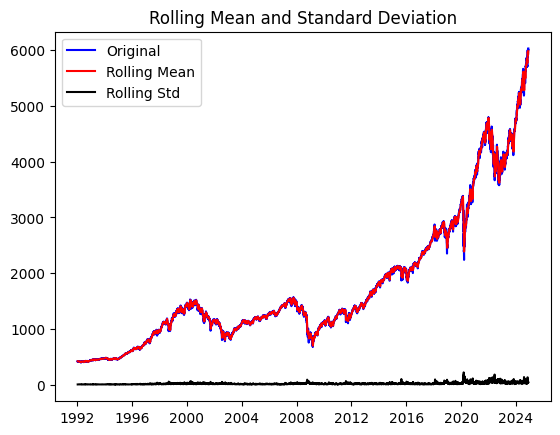

Results of dft
Test Statistics                   3.208697
p-value                           1.000000
No. of lags used                 30.000000
Number of observations used    8259.000000
critical value (1%)              -3.431142
critical value (5%)              -2.861890
critical value (10%)             -2.566956
dtype: float64


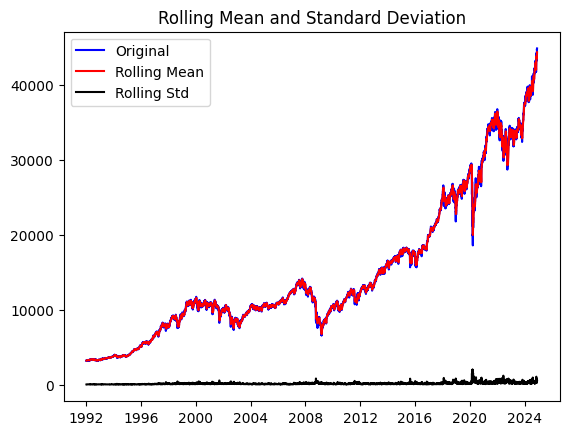

Results of dft
Test Statistics                   2.249609
p-value                           0.998921
No. of lags used                 31.000000
Number of observations used    8258.000000
critical value (1%)              -3.431142
critical value (5%)              -2.861890
critical value (10%)             -2.566956
dtype: float64


In [939]:
test_stationarity(sp500_data)
test_stationarity(dowjones_data)

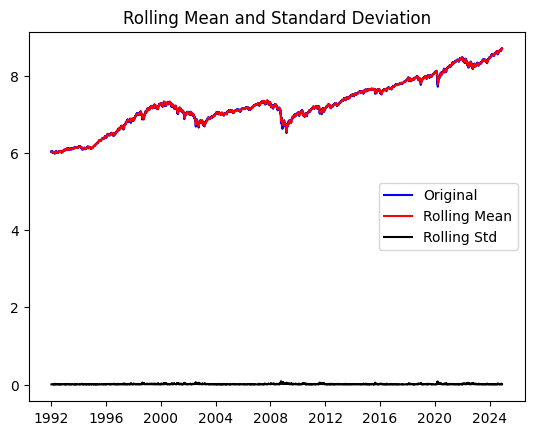

Results of dft
Test Statistics                  -0.135832
p-value                           0.945750
No. of lags used                 34.000000
Number of observations used    8255.000000
critical value (1%)              -3.431142
critical value (5%)              -2.861890
critical value (10%)             -2.566956
dtype: float64


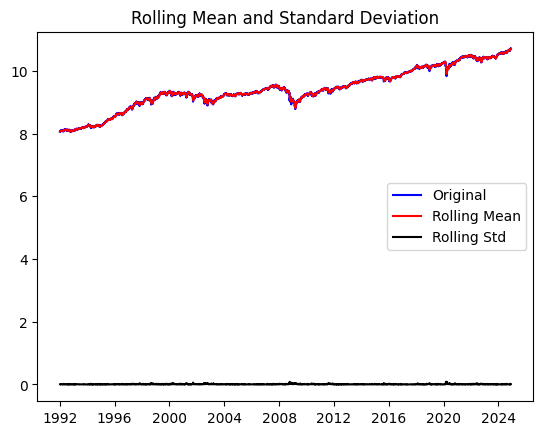

Results of dft
Test Statistics                  -0.678320
p-value                           0.852286
No. of lags used                 34.000000
Number of observations used    8255.000000
critical value (1%)              -3.431142
critical value (5%)              -2.861890
critical value (10%)             -2.566956
dtype: float64


In [940]:
sp500_data = np.log(sp500_data)
dowjones_data = np.log(dowjones_data)
test_stationarity(sp500_data)
test_stationarity(dowjones_data)


 GDP 



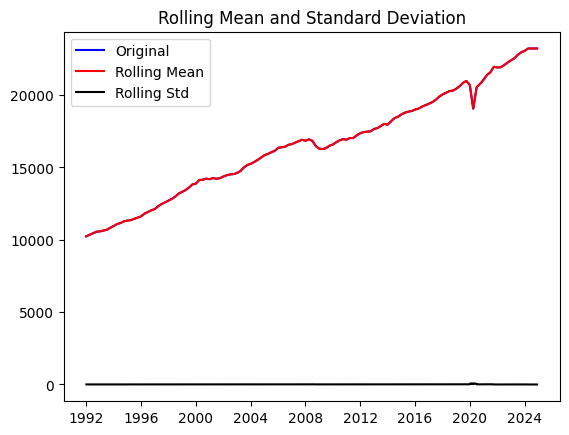

Results of dft
Test Statistics                  -0.036741
p-value                           0.955386
No. of lags used                 37.000000
Number of observations used    8252.000000
critical value (1%)              -3.431143
critical value (5%)              -2.861890
critical value (10%)             -2.566956
dtype: float64

 Unemployment Rate 



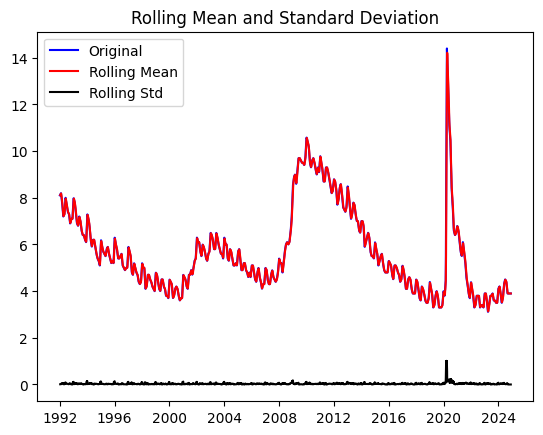

Results of dft
Test Statistics                  -3.229455
p-value                           0.018342
No. of lags used                 37.000000
Number of observations used    8252.000000
critical value (1%)              -3.431143
critical value (5%)              -2.861890
critical value (10%)             -2.566956
dtype: float64

 CPI 



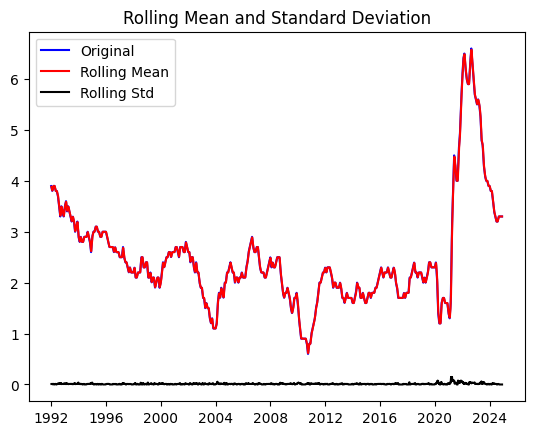

Results of dft
Test Statistics                  -2.711981
p-value                           0.071988
No. of lags used                 28.000000
Number of observations used    8261.000000
critical value (1%)              -3.431142
critical value (5%)              -2.861890
critical value (10%)             -2.566956
dtype: float64

 Interest Rates 



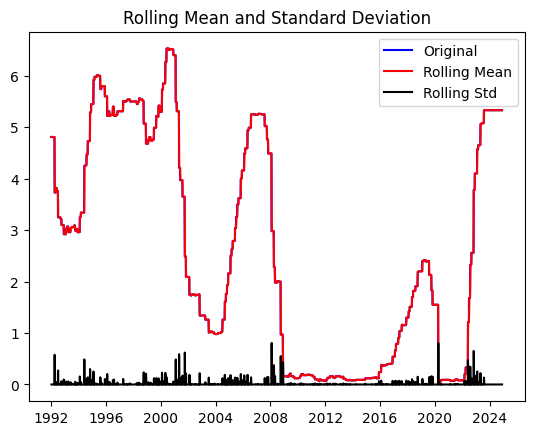

Results of dft
Test Statistics                  -1.110494
p-value                           0.710869
No. of lags used                 23.000000
Number of observations used    8266.000000
critical value (1%)              -3.431141
critical value (5%)              -2.861890
critical value (10%)             -2.566956
dtype: float64

 Consumer Confidence Index 



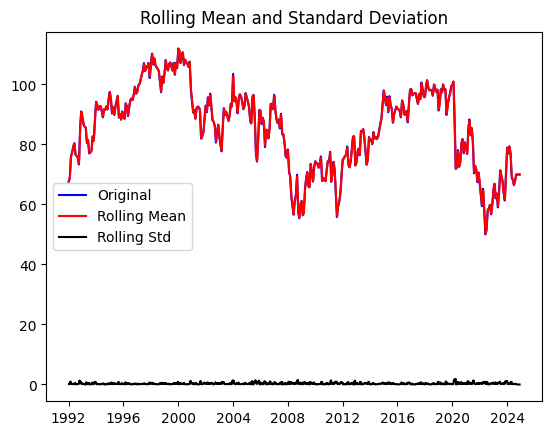

Results of dft
Test Statistics                  -2.344382
p-value                           0.158053
No. of lags used                 37.000000
Number of observations used    8252.000000
critical value (1%)              -3.431143
critical value (5%)              -2.861890
critical value (10%)             -2.566956
dtype: float64


In [941]:
for column in combined_exogenous_data.columns:
    print("\n",column, "\n")
    test_stationarity(combined_exogenous_data[column])

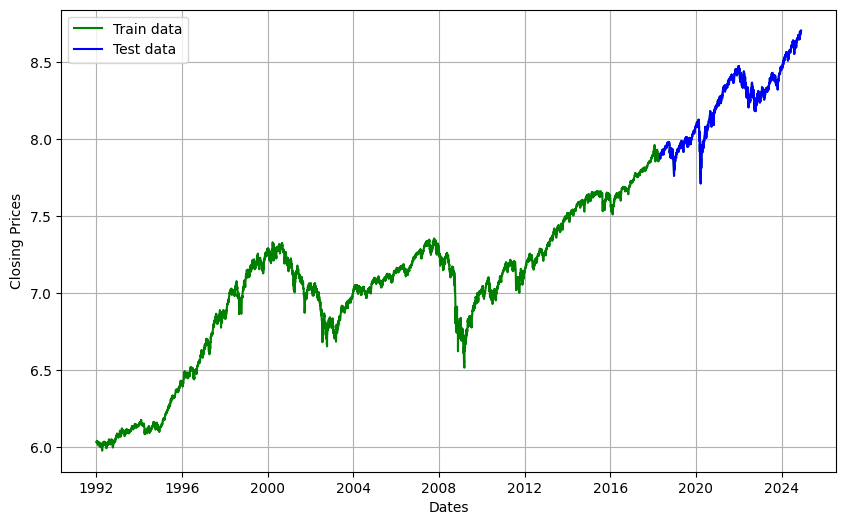

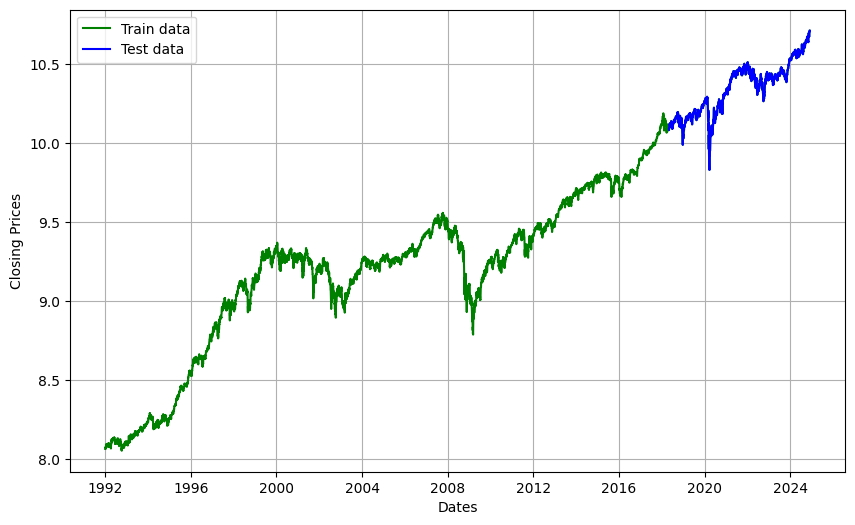

In [942]:
train_size = int(len(sp500_data) * 0.8)
train_sp500, test_sp500 = sp500_data[:train_size], sp500_data[train_size:]
train_dowjones, test_dowjones = dowjones_data[:train_size], dowjones_data[train_size:]
train_exog, test_exog = combined_exogenous_data[:train_size], combined_exogenous_data[train_size:]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(sp500_data, 'green', label='Train data')
plt.plot(test_sp500, 'blue', label='Test data')
plt.legend()

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(dowjones_data, 'green', label='Train data')
plt.plot(test_dowjones, 'blue', label='Test data')
plt.legend()


In [943]:
# Auto ARIMA with selected exogenous variables
auto_model = auto_arima(
    train_sp500,
    exogenous=train_exog,
    seasonal=False,
    d=None,
    trace=True,
    
)

auto_model = auto_arima(
    train_dowjones,
    exogenous=train_exog,
    seasonal=False,
    d=None,
    trace=True,
    
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-40772.231, Time=1.96 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-40738.886, Time=0.68 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-40762.226, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-40764.820, Time=2.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-40736.789, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-40775.045, Time=1.92 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-40777.106, Time=1.50 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-40775.057, Time=3.81 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-40775.348, Time=0.79 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-40772.677, Time=1.78 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-40773.885, Time=0.66 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 15.840 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-41436.129, Time=1.50 sec
 ARIMA(0,1,0)(0,0,0)

In [944]:
sarimax_model_sp500 = SARIMAX(
    train_sp500,
    exog=train_exog,
    order=(0,1,2),
)

results_sp500 = sarimax_model_sp500.fit()

print("S&P 500 Model Summary:")
print(results_sp500.summary())

sarimax_model_dowjones = SARIMAX(
    train_dowjones,
    exog=train_exog,
    order=(3,1,3),
)

results_dowjones = sarimax_model_dowjones.fit()

print("Dow Jones Model Summary:")
print(results_dowjones.summary())



S&P 500 Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  ^GSPC   No. Observations:                 6632
Model:               SARIMAX(0, 1, 2)   Log Likelihood               20405.639
Date:                Sun, 08 Dec 2024   AIC                         -40795.278
Time:                        23:54:05   BIC                         -40740.882
Sample:                             0   HQIC                        -40776.483
                               - 6632                                         
Covariance Type:                  opg                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
GDP                           0.0002   4.93e-05      4.648      0.000       0.000       0.000
Unemployment Rate             0.0033      0.006      0.530     

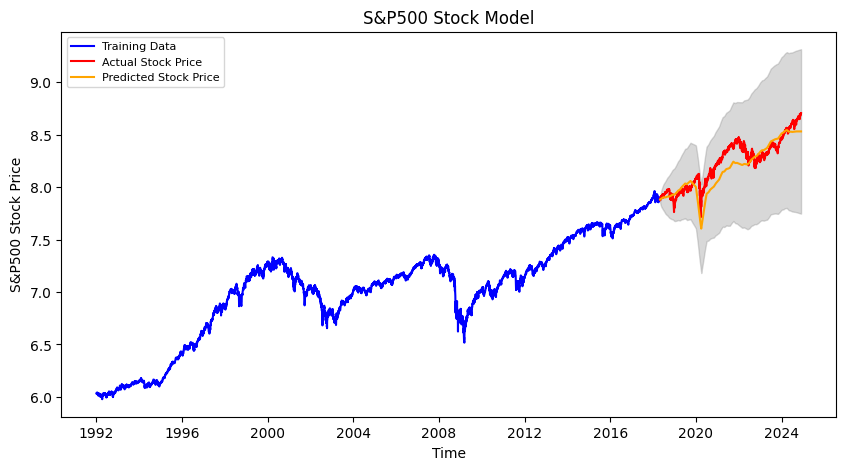

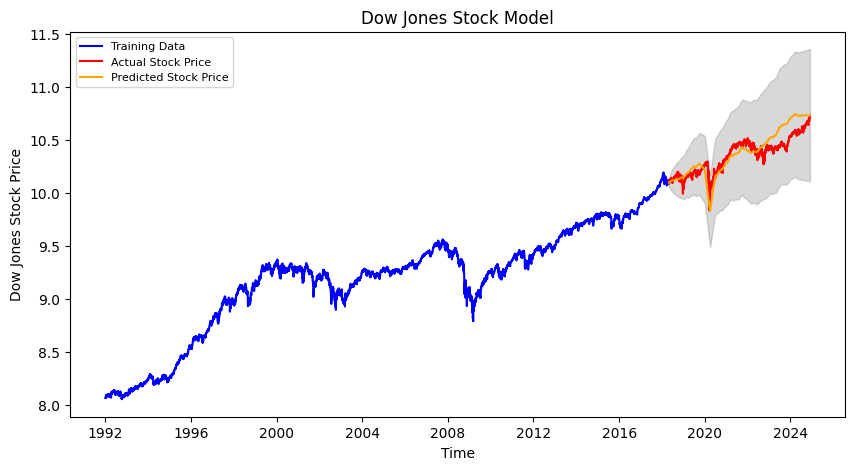

In [953]:
### S&P500

# Forecast
forecast_sp500 = results_sp500.get_forecast(
    steps=len(test_sp500), 
    exog=test_exog, 
    alpha=0.05
)

# Extract predicted mean and confidence intervals
fc_sp500 = forecast_sp500.predicted_mean
conf_sp500 = forecast_sp500.conf_int()



# Align indices
fc_sp500.index = test_sp500.index
conf_sp500.index = test_sp500.index

# Convert to pandas series
fc_series_sp500 = pd.Series(fc_sp500, index=test_sp500.index)
lower_series_sp500 = pd.Series(conf_sp500.iloc[:, 0], index=test_sp500.index)
upper_series_sp500 = pd.Series(conf_sp500.iloc[:, 1], index=test_sp500.index)

# Plot
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_sp500, label='Training Data', color='blue')
plt.plot(test_sp500, label='Actual Stock Price', color='red')
plt.plot(fc_series_sp500, label='Predicted Stock Price', color='orange')
plt.fill_between(
    lower_series_sp500.index, 
    lower_series_sp500, 
    upper_series_sp500, 
    color='gray', 
    alpha=0.3
)
plt.title('S&P500 Stock Model')
plt.xlabel('Time')
plt.ylabel('S&P500 Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()


### Dow

# Forecast
forecast_dowjones = results_dowjones.get_forecast(
    steps=len(test_dowjones), 
    exog=test_exog, 
    alpha=0.05
)

# Extract predicted mean and confidence intervals
fc_dowjones = forecast_dowjones.predicted_mean
conf_dowjones = forecast_dowjones.conf_int()

# Align indices
fc_dowjones.index = test_dowjones.index
conf_dowjones.index = test_dowjones.index

# Convert to pandas series
fc_series_dowjones = pd.Series(fc_dowjones, index=test_dowjones.index)
lower_series_dowjones = pd.Series(conf_dowjones.iloc[:, 0], index=test_dowjones.index)
upper_series_dowjones = pd.Series(conf_dowjones.iloc[:, 1], index=test_dowjones.index)

# Plot
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_dowjones, label='Training Data', color='blue')
plt.plot(test_dowjones, label='Actual Stock Price', color='red')
plt.plot(fc_series_dowjones, label='Predicted Stock Price', color='orange')
plt.fill_between(
    lower_series_dowjones.index, 
    lower_series_dowjones, 
    upper_series_dowjones, 
    color='gray', 
    alpha=0.3
)
plt.title('Dow Jones Stock Model')
plt.xlabel('Time')
plt.ylabel('Dow Jones Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()



In [946]:
combined_data_sp500 = pd.concat([sp500_data, combined_exogenous_data], axis=1)
correlation_matrix = combined_data_sp500.corr()
print(correlation_matrix["^GSPC"])

combined_data_dowjones = pd.concat([dowjones_data, combined_exogenous_data], axis=1)
correlation_matrix = combined_data_dowjones.corr()
print(correlation_matrix["^DJI"])


^GSPC                        1.000000
GDP                          0.953990
Unemployment Rate           -0.371884
CPI                          0.222204
Interest Rates              -0.262089
Consumer Confidence Index   -0.218449
Name: ^GSPC, dtype: float64
^DJI                         1.000000
GDP                          0.968195
Unemployment Rate           -0.331087
CPI                          0.162573
Interest Rates              -0.323363
Consumer Confidence Index   -0.236503
Name: ^DJI, dtype: float64


In [956]:

mae_sp500 = mean_absolute_error(test_sp500, fc_sp500)
print(f"S&P 500 - MAE: {mae_sp500}")

mae_dow = mean_absolute_error(test_dowjones, fc_dowjones)
print(f"Dow Jones - MAE: {mae_dow}")


S&P 500 - MAE: 0.0981331363021988
Dow Jones - MAE: 0.08502018818144061


In [948]:
def cross_validate(endog, exog, order=(1,1,1)):
    # Define time-series cross-validator
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Store results
    mae_list = []  # List to store Mean Absolute Error (MAE) for each fold

    # Loop through splits
    for train_index, test_index in tscv.split(endog):

        # Split data into train and test sets
        train_endog, test_endog = endog.iloc[train_index], endog.iloc[test_index]
        train_exog, test_exog = exog.iloc[train_index], exog.iloc[test_index]

        # Train ARIMAX model
        model = SARIMAX(train_endog, exog=train_exog, order=order)
        results = model.fit(disp=False)

        # Forecast on test data
        forecast = results.get_forecast(steps=len(test_endog), exog=test_exog)
        predictions = forecast.predicted_mean
        predictions.index = test_endog.index

        # Calculate MAE
        mae = np.mean(np.abs(predictions - test_endog))
        mae_list.append(mae)

    # Cross-validation results
    print("Cross-validated MAE scores:", mae_list)
    print("Average MAE:", np.mean(mae_list))


cross_validate(sp500_data, combined_exogenous_data, (0,1,2))
cross_validate(dowjones_data, combined_exogenous_data, (3,1,3))


Cross-validated MAE scores: [0.17376165448357478, 0.11527708383732169, 0.16901981287741305, 0.149711024315945, 0.18027668990235263]
Average MAE: 0.15760925308332144
Cross-validated MAE scores: [0.288701877840795, 0.04068143007282482, 0.16558159218224783, 0.1497777850329824, 0.10075967719802296]
Average MAE: 0.14910047246537458


In [949]:
future_steps = 252 

last_date = pd.to_datetime("2024-11-29")

future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps, freq='D')

future_exog = combined_exogenous_data.reindex(combined_exogenous_data.index.union(future_dates))

# print(future_exog)

future_exog["GDP"] = future_exog["GDP"].interpolate(method="linear",limit_direction="both")
future_exog["Unemployment Rate"] = future_exog["Unemployment Rate"].fillna(method="ffill")
future_exog["CPI"] = future_exog["CPI"].fillna(method="ffill")
future_exog["Interest Rates"] = future_exog["Interest Rates"].fillna(method="ffill")
future_exog["Consumer Confidence Index"] = future_exog["Consumer Confidence Index"].interpolate(method="linear")

future_exog = future_exog[last_date + pd.Timedelta(days=1):]


In [950]:
full_sp500 = pd.concat([train_sp500, test_sp500])
full_dowjones = pd.concat([train_dowjones, test_dowjones])
full_exog = pd.concat([train_exog, test_exog])

future_sp500_model = SARIMAX(full_sp500, exog=full_exog, order=(0, 1, 2))
future_sp500_results = future_sp500_model.fit()

future_dowjones_model = SARIMAX(full_dowjones, exog=full_exog, order=(3, 1, 3))
future_dowjones_results = future_dowjones_model.fit()

In [951]:
# Forecast S&P 500
forecast_sp500 = future_sp500_results.get_forecast(steps=future_steps, exog=future_exog)
predicted_sp500 = forecast_sp500.predicted_mean
conf_int_sp500 = forecast_sp500.conf_int()

# Forecast Dow Jones
forecast_dow = future_dowjones_results.get_forecast(steps=future_steps, exog=future_exog)
predicted_dow = forecast_dow.predicted_mean
conf_int_dow = forecast_dow.conf_int()

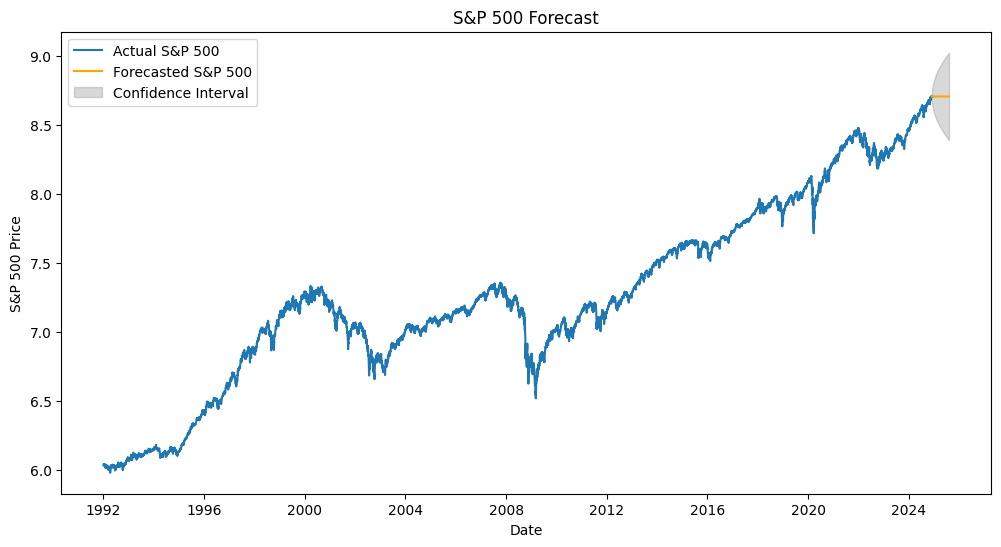

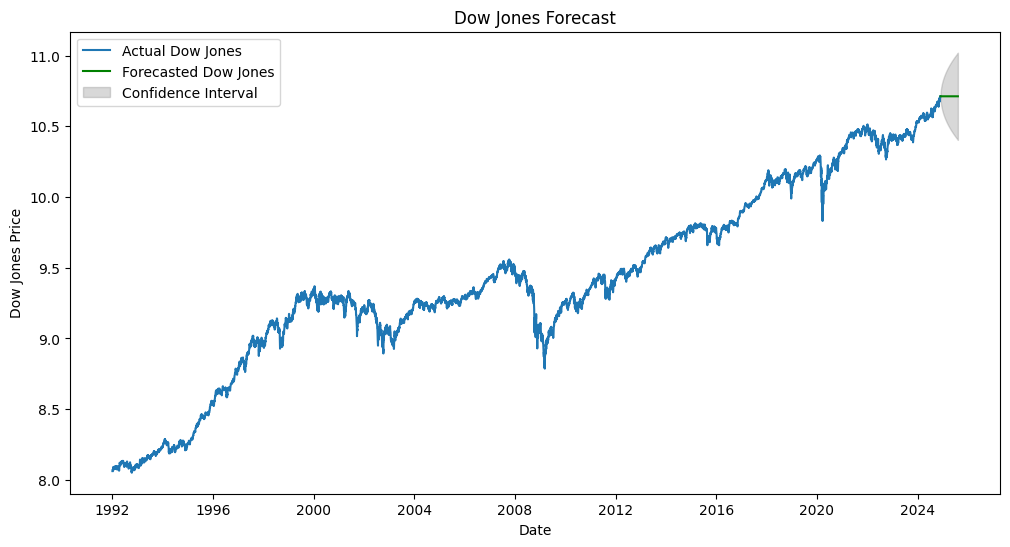

S&P500
2024-11-30    8.704460
2024-12-01    8.704374
2024-12-02    8.704374
2024-12-03    8.704374
2024-12-04    8.704374
                ...   
2025-08-04    8.704374
2025-08-05    8.704374
2025-08-06    8.704374
2025-08-07    8.704374
2025-08-08    8.704374
Freq: D, Name: predicted_mean, Length: 252, dtype: float64
Dow Jones
2024-11-30    10.712047
2024-12-01    10.712015
2024-12-02    10.712005
2024-12-03    10.711971
2024-12-04    10.711967
                ...    
2025-08-04    10.711895
2025-08-05    10.711895
2025-08-06    10.711895
2025-08-07    10.711895
2025-08-08    10.711895
Freq: D, Name: predicted_mean, Length: 252, dtype: float64


In [952]:
predicted_sp500.index = future_dates
conf_int_sp500.index = future_dates


predicted_dow.index = future_dates
conf_int_dow.index = future_dates

# Plot S&P 500 predictions
plt.figure(figsize=(12, 6))
plt.plot(sp500_data, label='Actual S&P 500')
plt.plot(predicted_sp500, label='Forecasted S&P 500', color='orange')
plt.fill_between(conf_int_sp500.index, conf_int_sp500.iloc[:, 0], conf_int_sp500.iloc[:, 1],
                color='gray', alpha=0.3, label='Confidence Interval')
plt.title('S&P 500 Forecast')
plt.xlabel('Date')
plt.ylabel('S&P 500 Price')
plt.legend()
plt.show()

# Plot Dow Jones predictions
plt.figure(figsize=(12, 6))
plt.plot(dowjones_data, label='Actual Dow Jones')
plt.plot(predicted_dow, label='Forecasted Dow Jones', color='green')
plt.fill_between(conf_int_dow.index, conf_int_dow.iloc[:, 0], conf_int_dow.iloc[:, 1],
                color='gray', alpha=0.3, label='Confidence Interval')
plt.title('Dow Jones Forecast')
plt.xlabel('Date')
plt.ylabel('Dow Jones Price')
plt.legend()
plt.show()

print("S&P500")
print(predicted_sp500)

print("Dow Jones")
print(predicted_dow)